# Recommended temperature IRF

Here we calculate an impulse-response function to match MAGICC's and FaIR's behaviour.

## Authors

All notebooks and plots in this repository were generated by the following authors:

- Zebedee Nicholls zebedee.nicholls@climate-energy-college.org
- Jared Lewis jared.lewis@climate-resource.com
- Malte Meinshausen malte.meinshausen@unimelb.edu.au

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import os.path
import warnings
from concurrent.futures import as_completed, ProcessPoolExecutor

import matplotlib.pyplot as plt
import numpy as np
import openscm_twolayermodel
import pandas as pd
import scmdata.database
import scipy.optimize
import seaborn as sns
import tqdm.autonotebook as tqdman
from openscm_units import unit_registry

/data/ubuntu-znicholls/miniconda3/envs/ar6-wg1-plots-and-processing/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [4]:
import utils

<IPython.core.display.Javascript object>

In [5]:
BEST_ESTIMATE_ECS = 3
BEST_ESTIMATE_TCR = 1.8
BEST_ESTIMATE_F2XCO2 = 3.93

<IPython.core.display.Javascript object>

In [6]:
MAGICC_IN_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "temperature_irfs",
    "irf_from_2xCO2_2021_02_17_233041.csv",
)
MAGICC_IN_FILE

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/irf_from_2xCO2_2021_02_17_233041.csv'

<IPython.core.display.Javascript object>

In [7]:
now = dt.datetime.now()
datestamp = now.strftime("%Y_%m_%d_%H%M%S")
datestamp

'2022_02_01_065221'

<IPython.core.display.Javascript object>

In [8]:
OUT_FILE_MAGICC = os.path.join(
    utils.DATA_DIR, "processed", "temperature_irfs", f"irf_from_2xCO2_{datestamp}.csv"
)
OUT_FILE_MAGICC

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/irf_from_2xCO2_2022_02_01_065221.csv'

<IPython.core.display.Javascript object>

In [9]:
OUT_FILE_RECOMMENDATION = os.path.join(
    utils.DATA_DIR,
    "processed",
    "temperature_irfs",
    f"recommended_irf_from_2xCO2_{datestamp}.csv",
)
OUT_FILE_RECOMMENDATION

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/recommended_irf_from_2xCO2_2022_02_01_065221.csv'

<IPython.core.display.Javascript object>

In [10]:
OUT_FILE_FAIR_RENAMED = os.path.join(
    os.path.dirname(OUT_FILE_RECOMMENDATION),
    f"fair_impulse_response_consistent_nomenclature_{datestamp}.csv",
)
OUT_FILE_FAIR_RENAMED

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/fair_impulse_response_consistent_nomenclature_2022_02_01_065221.csv'

<IPython.core.display.Javascript object>

In [11]:
summary_table = pd.read_csv(MAGICC_IN_FILE, index_col="id")
summary_table

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  \
id                                                              
median                         6.635937            158.985957   
5th percentile                14.214921            159.316394   
95th percentile                6.537695            158.972901   
ensemble member 18             6.638006            158.977297   
ensemble member 7             10.862616            159.788960   
...                                 ...                   ...   
ensemble member 589           12.587042            158.214405   
ensemble member 597            6.649942            158.976139   
ensemble member 583           17.177183            159.329547   
ensemble member 598            7.774907            159.033163   
ensemble member 588           14.926644            160.243025   

                     alpha (W / m^2 / K)  eta (dimensionless)  \
id                                                              
median                          1.315760             0.762407   
5th percentile                  1.749939             0.741420   
95th percentile                 0.931663             0.828348   
ensemble member 18              1.045640             0.619081   
ensemble member 7               1.088774             0.679554   
...                                  ...                  ...   
ensemble member 589             1.173144             0.971798   
ensemble member 597             0.911674             0.764637   
ensemble member 583             1.814964             0.825085   
ensemble member 598             1.428233             0.951177   
ensemble member 588             1.966532             0.745123   

                     kappa (W / m^2 / K)   d1 (yr)     d2 (yr)  \
id                                                               
median                          0.952867  3.226718  260.790006   
5th percentile                  1.086569  5.494943  216.751156   
95th percentile                 0.836230  3.988354  334.479366   
ensemble member 18              1.116366  3.781022  239.097169   
ensemble member 7               0.846742  6.448422  291.970330   
...                                  ...       ...         ...   
ensemble member 589             0.737131  6.582661  349.842194   
ensemble member 597             1.063727  3.808008  286.274191   
ensemble member 583             1.012503  6.395659  232.862046   
ensemble member 598             0.704345  3.685997  333.459461   
ensemble member 588             1.119249  5.269997  206.206870   

                     q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                            
median                         0.482819            0.277197   
5th percentile                 0.381753            0.189696   
95th percentile                0.604464            0.468885   
ensemble member 18             0.563388            0.392964   
ensemble member 7              0.586298            0.332166   
...                                 ...                 ...   
ensemble member 589            0.516654            0.335756   
ensemble member 597            0.565570            0.531313   
ensemble member 583            0.367290            0.183686   
ensemble member 598            0.471562            0.228604   
ensemble member 588            0.348983            0.159527   

                     efficacy (dimensionless)   ecs (K)   tcr (K)  \
id                                                                  
median                               0.762407  2.922792  1.902267   
5th percentile                       0.741420  1.905422  1.264958   
95th percentile                      0.828348  4.639324  2.661825   
ensemble member 18                   0.619081  3.692390  2.259617   
ensemble member 7                    0.679554  3.899937  2.416516   
...                                       ...       ...       ...   
ensemble member 589                  0.971798  2.865431  1.679195   
ensemble member 597          

<IPython.core.display.Javascript object>

ecs (K)
1.418043584127004
1.9054917580029571
2.919631802340613
4.672807393635287
6.9337987014131235

tcr (K)
0.9947123731182398
1.2746581918468094
1.8863171725970342
2.620041349048444
3.409271033872177



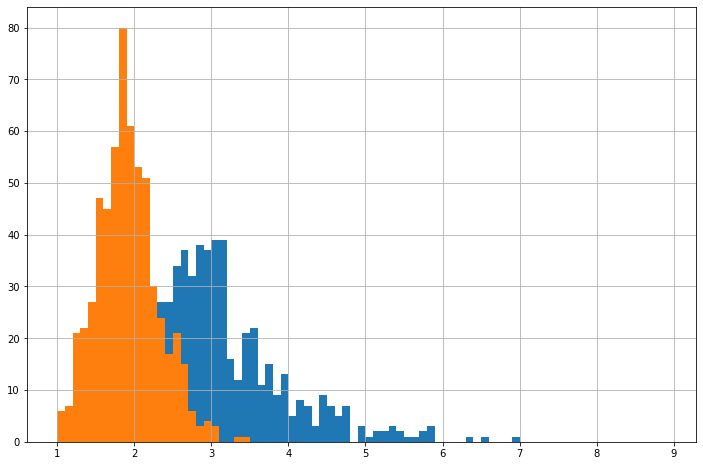

<IPython.core.display.Javascript object>

In [12]:
for col in [
    "ecs (K)",
    "tcr (K)",
    #     "C (W yr / m^2 / K)",
    #     "C_d (W yr / m^2 / K)",
    #     "alpha (W / m^2 / K)",
    #     "eta (dimensionless)",
    #     "kappa (W / m^2 / K)",
    #     "efficacy (dimensionless)",
]:
    print(col)
    summary_table[col].hist(bins=np.arange(1, 9, 0.1))
    print(summary_table[col].quantile(q=0))
    print(summary_table[col].quantile(q=0.05))
    print(summary_table[col].median())
    print(summary_table[col].quantile(q=0.95))
    print(summary_table[col].quantile(q=1))
    print()

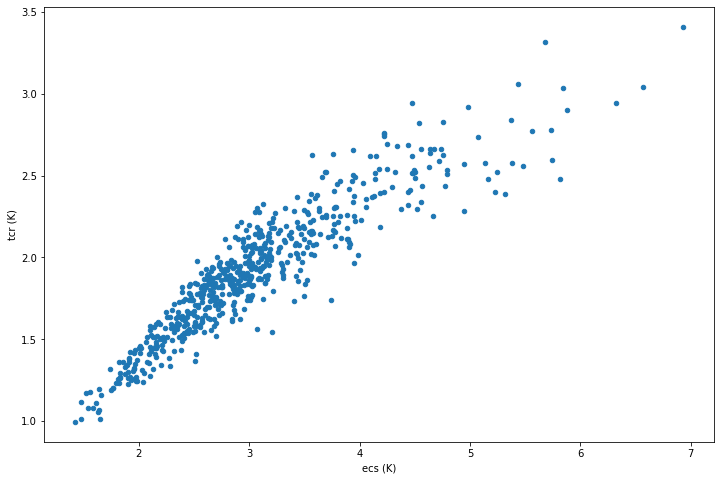

<IPython.core.display.Javascript object>

In [13]:
summary_table.plot.scatter(x="ecs (K)", y="tcr (K)")

## Expert judgement and final recommendation

In [14]:
def _convert_d_units(ind):
    ind["d1"] = ind["d1"].to("yr")
    ind["d2"] = ind["d2"].to("yr")

    return ind

<IPython.core.display.Javascript object>

In [15]:
def get_summary_paras(mod, name, driver):
    # rebuild the mod_calc to avoid conflicting unit registry errors
    mod_calc = get_irf_model(
        [
            mod.dl.magnitude,
            mod.du.magnitude,
            mod.eta.magnitude,
            mod.lambda0.magnitude,
            mod.efficacy.magnitude,
        ]
    )
    ar6name_attribute_units = (
        ("C", "heat_capacity_upper", "W yr / m^2 / K"),
        ("C_d", "heat_capacity_lower", "W yr / m^2 / K"),
        ("alpha", "lambda0", "W / m^2 / K"),
        ("eta", "efficacy", "dimensionless"),
        ("kappa", "eta", "W / m^2 / K"),
    )
    two_layer_paras = {
        "{} ({})".format(name, unit): getattr(mod_calc, attribute).to(unit).magnitude
        for name, attribute, unit in ar6name_attribute_units
    }

    irf_units = (
        ("d1", "yr"),
        ("d2", "yr"),
        ("q1", "K / (W / m^2)"),
        ("q2", "K / (W / m^2)"),
        ("efficacy", "dimensionless"),
    )
    irf_paras = mod_calc.get_impulse_response_parameters()
    irf_paras = {
        "{} ({})".format(name, unit): irf_paras[name].to(unit).magnitude
        for name, unit in irf_units
    }

    out = {**two_layer_paras, **irf_paras}
    out["id"] = name
    out["ecs (K)"] = calc_ecs(mod_calc, driver).to("K").magnitude
    out["tcr (K)"] = calc_tcr(mod_calc, driver).to("K").magnitude
    out["rf2xCO2 (W / m^2)"] = driver.iloc[0, 0]
    return out

<IPython.core.display.Javascript object>

In [16]:
def get_irf_model(in_vec):
    dl, du, eta, lambda0, efficacy = in_vec

    impulse_response = openscm_twolayermodel.TwoLayerModel(
        dl=dl * unit_registry("m"),
        du=du * unit_registry("m"),
        eta=eta * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
        lambda0=lambda0 * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
        efficacy=efficacy * unit_registry("dimensionless"),
    )

    return impulse_response

<IPython.core.display.Javascript object>

In [17]:
def calc_ecs(mod, driver):
    rf2xco2 = driver.iloc[0, 0] * unit_registry("W / m^2")

    impulse_response_paras = mod.get_impulse_response_parameters()
    ecs = rf2xco2 * (impulse_response_paras["q1"] + impulse_response_paras["q2"])

    return ecs

<IPython.core.display.Javascript object>

In [18]:
t0 = 70 * unit_registry("yr")


def _calc_term(q, d):
    return q * (1 - d / t0 * (1 - np.exp(-t0 / d)))


def calc_tcr(mod, driver):
    rf2xco2 = driver.iloc[0, 0] * unit_registry("W / m^2")

    impulse_response_paras = mod.get_impulse_response_parameters()
    tcr = rf2xco2 * (
        _calc_term(impulse_response_paras["q1"], impulse_response_paras["d1"])
        + _calc_term(impulse_response_paras["q2"], impulse_response_paras["d2"])
    )

    return tcr

<IPython.core.display.Javascript object>

In [19]:
fair_params_df = pd.read_csv(
    os.path.join(
        utils.DATA_DIR, "raw", "fair", utils.FAIR_VERSION, "impulse_response.csv"
    ),
    index_col=0,
)  #
# Chris uses different notation
fair_params_df["kappa (W / m^2 / K)"] = fair_params_df["gamma (W / m^2 / K)"]
fair_params_df = fair_params_df.drop("gamma (W / m^2 / K)", axis="columns")
fair_params_df

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  \
id                                                          
median                     8.323784            122.471519   
5th percentile             6.030788             58.511844   
95th percentile           10.118715            258.464899   
156                        8.810878            448.213437   
358                        9.691545            103.494497   
...                             ...                   ...   
996792                     8.745431             62.417455   
996846                     9.089493            452.306881   
998289                     7.878012            109.737561   
998908                     9.221984            128.496448   
999021                     9.764826             47.657547   

                 alpha (W / m^2 / K)  kappa (W / m^2 / K)   d1 (yr)  \
id                                                                    
median                      1.367374             0.655173  3.696960   
5th percentile              0.803818             0.465854  2.214454   
95th percentile             1.947091             0.893993  5.649316   
156                         1.714643             0.440273  4.716124   
358                         1.817834             0.772469  3.154765   
...                              ...                  ...       ...   
996792                      1.281183             0.755601  3.369789   
996846                      1.881943             0.565309  4.160331   
998289                      1.436389             0.522615  3.656087   
998908                      1.409111             0.521846  4.101466   
999021                      1.471653             0.499383  5.164611   

                     d2 (yr)  q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                                     
median            314.073147            0.443775            0.283259   
5th percentile    147.403762            0.322272            0.099317   
95th percentile   758.454277            0.611524            0.737910   
156              1109.234044            0.535057            0.048155   
358               226.416477            0.322344            0.227762   
...                      ...                 ...                 ...   
996792            167.332810            0.377198            0.403331   
996846            928.864999            0.457376            0.073989   
998289            314.993589            0.461362            0.234828   
998908            392.906106            0.441954            0.267713   
999021            122.608100            0.522276            0.157232   

                 efficacy (dimensionless)   ecs (K)   tcr (K)  \
id                                                              
median                           1.293304  2.953389  1.814646   
5th percentile                   0.613726  2.054515  1.311732   
95th percentile                  2.000437  5.071012  2.569876   
156                              0.347264  2.115349  1.942170   
358                              1.585394  2.133679  1.274830   
...                                   ...       ...       ...   
996792                           1.668154  3.203013  1.614565   
996846                           0.532951  2.170608  1.871068   
998289                           1.350649  2.571759  1.724371   
998908                           1.581632  2.758806  1.739763   
999021                           0.793753  2.382116  1.876645   

                 erf2xCO2 (W / m^2)  
id                                   
median                     4.037403  
5th percentile             3.563371  
95th percentile            4.498439  
156                        3.627068  
358                        3.878673  
...                             ...  
996792                     4.103645  
996846                     4.084962  
998289                     3.694047  
998908                     3.887464  
999021                     3.505647  

[2240 rows x 12 colum

<IPython.core.display.Javascript object>

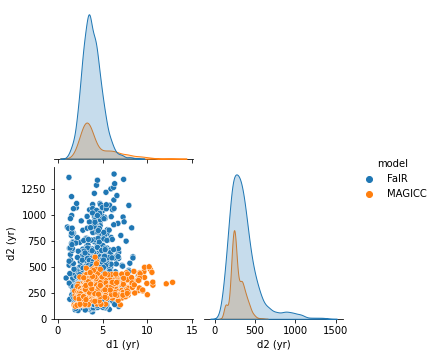

<IPython.core.display.Javascript object>

In [20]:
to_plot = ["d1 (yr)", "d2 (yr)"]

fair_df = fair_params_df[to_plot].copy()
fair_df["model"] = "FaIR"
magicc_df = summary_table[to_plot].copy()
magicc_df["model"] = "MAGICC"
sns_df = pd.concat([fair_df, magicc_df])
sns.pairplot(sns_df[to_plot + ["model"]], hue="model", corner=True)

In [21]:
fm = fair_params_df.loc["median"]
fair_median = openscm_twolayermodel.TwoLayerModel(
    dl=(
        fm["C_d (W yr / m^2 / K)"]
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    du=(
        fm["C (W yr / m^2 / K)"]
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    eta=fm["kappa (W / m^2 / K)"]
    * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
    lambda0=fm["alpha (W / m^2 / K)"]
    * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
    efficacy=fm["efficacy (dimensionless)"] * unit_registry("dimensionless"),
)
fair_median_impulse_response_paras = fair_median.get_impulse_response_parameters()
_convert_d_units(fair_median_impulse_response_paras)

{'d1': 3.7293575903819267 <Unit('a')>,
 'd2': 305.1252425332222 <Unit('a')>,
 'q1': 0.4445309911124588 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'q2': 0.28679762704557704 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'efficacy': 1.2933039817859375 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [22]:
fm = fair_params_df.loc["median"]
tmp = openscm_twolayermodel.ImpulseResponseModel(
    d1=(fm["d1 (yr)"] * unit_registry("yr")),
    d2=(fm["d2 (yr)"] * unit_registry("yr")),
    q1=(fm["q1 (K / (W / m^2))"] * unit_registry("K / (W / m^2)")),
    q2=(fm["q2 (K / (W / m^2))"] * unit_registry("K / (W / m^2)")),
    efficacy=fm["efficacy (dimensionless)"] * unit_registry("dimensionless"),
)
fair_median_two_layer_parameters = tmp.get_two_layer_parameters()
fair_median_two_layer_parameters["du"] = fair_median_two_layer_parameters["du"].to("m")
fair_median_two_layer_parameters["dl"] = fair_median_two_layer_parameters["dl"].to("m")
fair_median_two_layer_parameters

{'lambda0': 1.375452310455568 <Unit('watt / kelvin / meter ** 2')>,
 'du': 62.4101189214372 <Unit('meter')>,
 'dl': 952.1222089296688 <Unit('meter')>,
 'eta': 0.6530990355033169 <Unit('watt / kelvin / meter ** 2')>,
 'efficacy': 1.2933039817859375 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [23]:
fair_median_erf = scmdata.ScmRun(
    index=range(1850, 4000 + 1),
    data=np.ones(4000 + 1 - 1850) * fm["erf2xCO2 (W / m^2)"],
    columns={
        "variable": "Effective Radiative Forcing",
        "scenario": "abrupt-2xCO2",
        "unit": "W / m^2",
        "region": "World",
        "model": "unspecified",
    },
).timeseries()
fair_median_erf
get_summary_paras(
    fair_median,
    "fair_median",
    fair_median_erf,
)

{'C (W yr / m^2 / K)': 8.323783685372916,
 'C_d (W yr / m^2 / K)': 122.47151856698692,
 'alpha (W / m^2 / K)': 1.3673743583543216,
 'eta (dimensionless)': 1.2933039817859375,
 'kappa (W / m^2 / K)': 0.6551734521021042,
 'd1 (yr)': 3.7293575903819267,
 'd2 (yr)': 305.1252425332222,
 'q1 (K / (W / m^2))': 0.4445309911124588,
 'q2 (K / (W / m^2))': 0.28679762704557704,
 'efficacy (dimensionless)': 1.2933039817859375,
 'id': 'fair_median',
 'ecs (K)': 2.952668347914041,
 'tcr (K)': 1.8223536803071871,
 'rf2xCO2 (W / m^2)': 4.037402987662089}

<IPython.core.display.Javascript object>

In [24]:
magicc_median = summary_table.loc["median"].to_dict()
best_model_median = openscm_twolayermodel.TwoLayerModel(
    dl=(
        magicc_median["C_d (W yr / m^2 / K)"]
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    du=(
        magicc_median["C (W yr / m^2 / K)"]
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    eta=magicc_median["kappa (W / m^2 / K)"]
    * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
    lambda0=magicc_median["alpha (W / m^2 / K)"]
    * unit_registry("watt / delta_degree_Celsius / meter ** 2"),
    efficacy=magicc_median["efficacy (dimensionless)"] * unit_registry("dimensionless"),
)

<IPython.core.display.Javascript object>

In [25]:
erf_median = fair_median_erf.copy()
erf_median.iloc[:, :] = magicc_median["rf2xCO2 (W / m^2)"]

<IPython.core.display.Javascript object>

In [26]:
def _get_average(a, b, p):
    return (getattr(a, p) + getattr(b, p)) / 2

<IPython.core.display.Javascript object>

In [27]:
recommendation_average = openscm_twolayermodel.TwoLayerModel(
    dl=_get_average(fair_median, best_model_median, "dl"),
    du=_get_average(fair_median, best_model_median, "du"),
    eta=_get_average(fair_median, best_model_median, "eta"),
    lambda0=_get_average(fair_median, best_model_median, "lambda0"),
    efficacy=_get_average(fair_median, best_model_median, "efficacy"),
)
recommendation_average_impulse_response_parameters = (
    recommendation_average.get_impulse_response_parameters()
)
_convert_d_units(recommendation_average_impulse_response_parameters)

{'d1': 3.4241020923110064 <Unit('a')>,
 'd2': 285.00347784191143 <Unit('a')>,
 'q1': 0.4542786539453724 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'q2': 0.2911181626591603 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
 'efficacy': 1.027855508920276 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [28]:
def calculate_q(tcrecs, d, f2x, tcr_dbl, nt):
    """
    If TCR and ECS are supplied, calculate the q model coefficients.
    See Eqs. (4) and (5) of Millar et al ACP (2017).
    Inputs:
        tcrecs  : 2-element array of transient climate response (TCR) and
                  equilibrium climate sensitivity (ECS).
        d       : The slow and fast thermal response time constants
        f2x     : Effective radiative forcing from a doubling of CO2
        tcr_dbl : time to a doubling of CO2 under 1% per year CO2 increase, yr
        nt      : number of timesteps
    Outputs:
        q       : coefficients of slow and fast temperature change in each
                  timestep ((nt, 2) array).

    Copied from the FaIR repository https://github.com/OMS-NetZero/FAIR
    """
    k = 1.0 - (d / tcr_dbl) * (1.0 - np.exp(-tcr_dbl / d))

    if tcrecs.ndim == 1:
        if len(tcrecs) != 2:
            raise ValueError("Constant TCR and ECS should be a 2-element array")
        tcrecs = np.ones((nt, 2)) * tcrecs
    elif tcrecs.ndim == 2:
        if tcrecs.shape != (nt, 2):
            raise ValueError("Transient TCR and ECS should be a nt x 2 array")
    q = (
        (1.0 / f2x)
        * (1.0 / (k[0] - k[1]))
        * np.array(
            [tcrecs[:, 0] - tcrecs[:, 1] * k[1], tcrecs[:, 1] * k[0] - tcrecs[:, 0]]
        ).T
    )

    return q

<IPython.core.display.Javascript object>

Update the averages so ECS and TCR are matched.

In [29]:
updated_q = calculate_q(
    np.array([BEST_ESTIMATE_TCR, BEST_ESTIMATE_ECS]),
    np.array(
        [
            recommendation_average_impulse_response_parameters["d1"].to("yr").magnitude,
            recommendation_average_impulse_response_parameters["d2"].to("yr").magnitude,
        ]
    ),
    BEST_ESTIMATE_F2XCO2,
    np.log(2) / np.log(1.01),
    1,
)
display(updated_q)
fast_q = updated_q[0][0]
display(fast_q)
slow_q = updated_q[0][1]
display(slow_q)

array([[0.44376773, 0.31959105]])

0.4437677288834475

0.3195910497425067

<IPython.core.display.Javascript object>

In [30]:
recommendation_irf = openscm_twolayermodel.ImpulseResponseModel(
    d1=recommendation_average_impulse_response_parameters["d1"],
    d2=recommendation_average_impulse_response_parameters["d2"],
    q1=(fast_q * unit_registry("K / (W / m^2)")),
    q2=(slow_q * unit_registry("K / (W / m^2)")),
    efficacy=recommendation_average_impulse_response_parameters["efficacy"],
)
recommendation_two_layer_parameters = recommendation_irf.get_two_layer_parameters()
recommendation_two_layer_parameters["du"] = recommendation_two_layer_parameters[
    "du"
].to("m")
recommendation_two_layer_parameters["dl"] = recommendation_two_layer_parameters[
    "dl"
].to("m")
recommendation_two_layer_parameters

{'lambda0': 1.31 <Unit('watt / kelvin / meter ** 2')>,
 'du': 57.73953358850204 <Unit('meter')>,
 'dl': 1110.8078463278987 <Unit('meter')>,
 'eta': 0.8806360314640469 <Unit('watt / kelvin / meter ** 2')>,
 'efficacy': 1.027855508920276 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [31]:
recommendation = openscm_twolayermodel.TwoLayerModel(
    **recommendation_two_layer_parameters
)
_convert_d_units(recommendation.get_impulse_response_parameters())

{'d1': 3.424102092311003 <Unit('a')>,
 'd2': 285.0034778419114 <Unit('a')>,
 'q1': 0.44376772888344707 <Unit('kelvin * meter ** 2 / watt')>,
 'q2': 0.31959104974250885 <Unit('kelvin * meter ** 2 / watt')>,
 'efficacy': 1.027855508920276 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [32]:
recommendation_erf = fair_median_erf.copy()
recommendation_erf.iloc[:, :] = BEST_ESTIMATE_F2XCO2
recommendation_erf
recommendation_summary = get_summary_paras(
    recommendation,
    "recommendation",
    recommendation_erf,
)
np.testing.assert_allclose(recommendation_summary["tcr (K)"], 1.8, rtol=1e-3)
np.testing.assert_allclose(recommendation_summary["ecs (K)"], 3, rtol=1e-3)
recommendation_summary

{'C (W yr / m^2 / K)': 7.6497892721096346,
 'C_d (W yr / m^2 / K)': 147.1685934765934,
 'alpha (W / m^2 / K)': 1.31,
 'eta (dimensionless)': 1.027855508920276,
 'kappa (W / m^2 / K)': 0.8806360314640469,
 'd1 (yr)': 3.424102092311003,
 'd2 (yr)': 285.0034778419114,
 'q1 (K / (W / m^2))': 0.44376772888344707,
 'q2 (K / (W / m^2))': 0.31959104974250885,
 'efficacy (dimensionless)': 1.027855508920276,
 'id': 'recommendation',
 'ecs (K)': 3.0000000000000067,
 'tcr (K)': 1.801051507167356,
 'rf2xCO2 (W / m^2)': 3.93}

<IPython.core.display.Javascript object>

In [33]:
ch7_A_2 = openscm_twolayermodel.TwoLayerModel(
    dl=(
        109
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    du=(
        8.2
        * unit_registry("W yr / m^2 / K")
        / openscm_twolayermodel.constants.DENSITY_WATER
        / openscm_twolayermodel.constants.HEAT_CAPACITY_WATER
    ).to("m"),
    # only product of eta and efficacy is defined by Ch. 7 A.2
    eta=0.86 * unit_registry("W / m^2 / K") / recommendation.efficacy,
    lambda0=4 / 3 * unit_registry("W / m^2 / K"),
    efficacy=recommendation.efficacy,
)
_convert_d_units(ch7_A_2.get_impulse_response_parameters())

{'d1': 3.6962800515041367 <Unit('a')>,
 'd2': 216.75561765425178 <Unit('a')>,
 'q1': 0.4455745681844746 <Unit('kelvin * meter ** 2 / watt')>,
 'q2': 0.3044254318155242 <Unit('kelvin * meter ** 2 / watt')>,
 'efficacy': 1.027855508920276 <Unit('dimensionless')>}

<IPython.core.display.Javascript object>

In [34]:
get_summary_paras(
    ch7_A_2,
    "Ch. 7.A.2",
    recommendation_erf,
)

{'C (W yr / m^2 / K)': 8.199999999999998,
 'C_d (W yr / m^2 / K)': 108.99999999999999,
 'alpha (W / m^2 / K)': 1.3333333333333333,
 'eta (dimensionless)': 1.027855508920276,
 'kappa (W / m^2 / K)': 0.8366934773773776,
 'd1 (yr)': 3.6962800515041367,
 'd2 (yr)': 216.75561765425178,
 'q1 (K / (W / m^2))': 0.4455745681844746,
 'q2 (K / (W / m^2))': 0.3044254318155242,
 'efficacy (dimensionless)': 1.027855508920276,
 'id': 'Ch. 7.A.2',
 'ecs (K)': 2.9474999999999953,
 'tcr (K)': 1.8326067669178223,
 'rf2xCO2 (W / m^2)': 3.93}

<IPython.core.display.Javascript object>

In [35]:
def add_line(
    model, driver, ax, colour="tab:blue", label="line", xlim=None, linestyle="-"
):
    res = model.run_scenarios(scmdata.ScmRun(driver.copy()))
    ax.plot(
        res["time"],
        res.filter(variable="Surface Temperature|Upper").values.squeeze(),
        color=colour,
        label=label,
        linestyle=linestyle,
    )

    if xlim is not None:
        ax.set_xlim(xlim)

    return ax

<IPython.core.display.Javascript object>

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

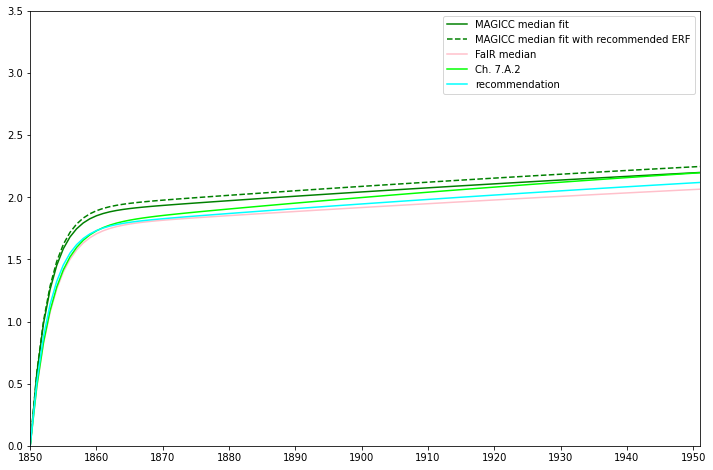

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

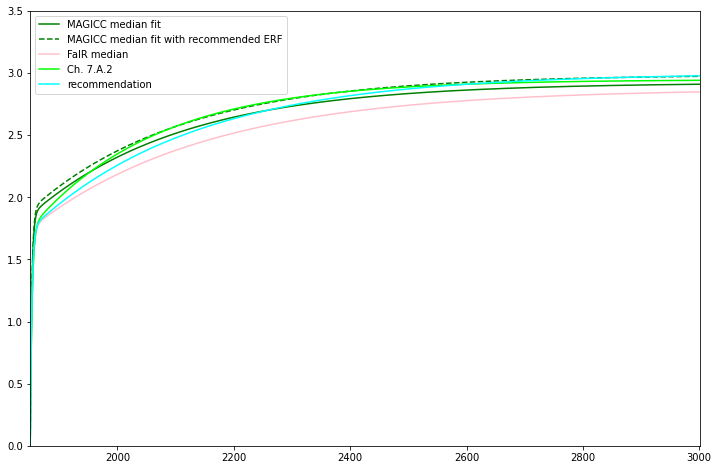

<IPython.core.display.Javascript object>

In [36]:
ylim = [0, 3.5]

for xlim in (
    [dt.datetime(1850, 1, 1), dt.datetime(1950, 12, 31)],
    [dt.datetime(1850, 1, 1), dt.datetime(3000, 12, 31)],
):
    ax = plt.figure().add_subplot(111)
    add_line(
        best_model_median,
        erf_median,
        ax,
        colour="green",
        label="MAGICC median fit",
        xlim=xlim,
    )
    add_line(
        best_model_median,
        recommendation_erf,
        ax,
        colour="green",
        label="MAGICC median fit with recommended ERF",
        linestyle="--",
        xlim=xlim,
    )
    add_line(
        fair_median,
        recommendation_erf,
        ax,
        colour="pink",
        label="FaIR median",
        xlim=xlim,
    )
    add_line(
        ch7_A_2,
        recommendation_erf,
        ax,
        colour="lime",
        label="Ch. 7.A.2",
        xlim=xlim,
    )
    add_line(
        recommendation,
        recommendation_erf,
        ax,
        colour="cyan",
        label="recommendation",
        xlim=xlim,
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend()
    plt.show()

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

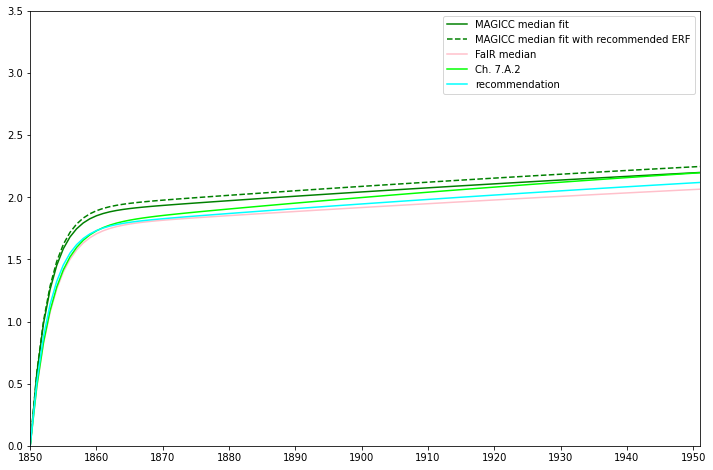

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

scenarios: 0it [00:00, ?it/s]

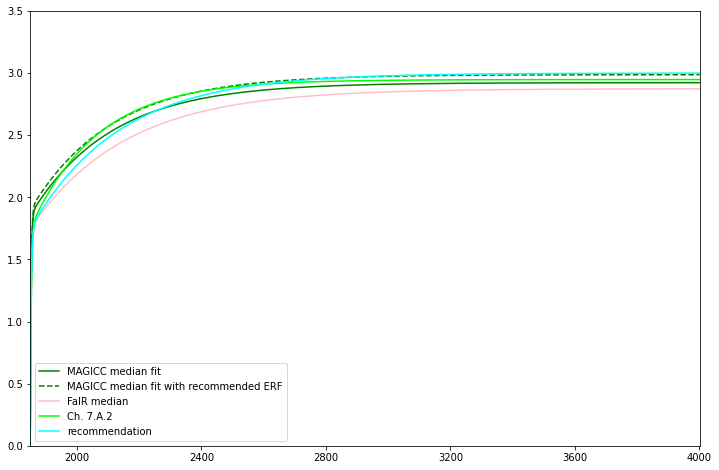

<IPython.core.display.Javascript object>

In [37]:
for xlim in (
    [dt.datetime(1850, 1, 1), dt.datetime(1950, 12, 31)],
    [dt.datetime(1850, 1, 1), dt.datetime(4000, 12, 31)],
):
    ax = plt.figure().add_subplot(111)

    add_line(
        best_model_median,
        erf_median,
        ax,
        colour="green",
        label="MAGICC median fit",
        xlim=xlim,
    )
    add_line(
        best_model_median,
        recommendation_erf,
        ax,
        colour="green",
        label="MAGICC median fit with recommended ERF",
        linestyle="--",
        xlim=xlim,
    )
    add_line(
        fair_median,
        recommendation_erf,
        ax,
        colour="pink",
        label="FaIR median",
        xlim=xlim,
    )
    add_line(
        ch7_A_2,
        recommendation_erf,
        ax,
        colour="lime",
        label="Ch. 7.A.2",
        xlim=xlim,
    )
    add_line(
        recommendation,
        recommendation_erf,
        ax,
        colour="cyan",
        label="recommendation",
        xlim=xlim,
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend()
    plt.show()
#     compare_plot(
#         surface_temp_median,
#         v2020_12_02_050025_median,
#         recommendation_erf,
#         ax=ax,
#         palette=["green", "tab:orange"],
#     )
#     compare_plot(
#         surface_temp_median,
#         recommendation,
#         recommendation_erf,
#         ax=ax,
#         palette=["red", "tab:orange"],
#     )
#     compare_plot(
#         surface_temp_median,
#         fair_median,
#         recommendation_erf,
#         ax=ax,
#         palette=["pink", "tab:orange"],
#     )
#     compare_plot(
#         surface_temp_median,
#         ch7_A_2,
#         recommendation_erf,
#         ax=ax,
#         palette=["lime", "tab:orange"],
#     )

#     ax.set_xlim(xlim)
#     plt.show()

In [38]:
pd.DataFrame(
    [
        get_summary_paras(
            recommendation,
            "recommendation",
            recommendation_erf,
        ),
        get_summary_paras(
            ch7_A_2,
            "Ch. 7.A.2",
            recommendation_erf,
        ),
        get_summary_paras(
            fair_median,
            "fair_median",
            fair_median_erf,
        ),
        get_summary_paras(
            fair_median,
            "fair_median_best_erf",
            recommendation_erf,
        ),
        get_summary_paras(best_model_median, "magicc_median", erf_median),
        get_summary_paras(
            best_model_median, "magicc_median_best_erf", recommendation_erf
        ),
    ],
).set_index("id")

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  \
id                                                                 
recommendation                    7.649789            147.168593   
Ch. 7.A.2                         8.200000            109.000000   
fair_median                       8.323784            122.471519   
fair_median_best_erf              8.323784            122.471519   
magicc_median                     6.635937            158.985957   
magicc_median_best_erf            6.635937            158.985957   

                        alpha (W / m^2 / K)  eta (dimensionless)  \
id                                                                 
recommendation                     1.310000             1.027856   
Ch. 7.A.2                          1.333333             1.027856   
fair_median                        1.367374             1.293304   
fair_median_best_erf               1.367374             1.293304   
magicc_median                      1.315760             0.762407   
magicc_median_best_erf             1.315760             0.762407   

                        kappa (W / m^2 / K)   d1 (yr)     d2 (yr)  \
id                                                                  
recommendation                     0.880636  3.424102  285.003478   
Ch. 7.A.2                          0.836693  3.696280  216.755618   
fair_median                        0.655173  3.729358  305.125243   
fair_median_best_erf               0.655173  3.729358  305.125243   
magicc_median                      0.952867  3.226718  260.790006   
magicc_median_best_erf             0.952867  3.226718  260.790006   

                        q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                               
recommendation                    0.443768            0.319591   
Ch. 7.A.2                         0.445575            0.304425   
fair_median                       0.444531            0.286798   
fair_median_best_erf              0.444531            0.286798   
magicc_median                     0.482819            0.277197   
magicc_median_best_erf            0.482819            0.277197   

                        efficacy (dimensionless)   ecs (K)   tcr (K)  \
id                                                                     
recommendation                          1.027856  3.000000  1.801052   
Ch. 7.A.2                               1.027856  2.947500  1.832607   
fair_median                             1.293304  2.952668  1.822354   
fair_median_best_erf                    1.293304  2.874121  1.773875   
magicc_median                           0.762407  2.922792  1.902267   
magicc_median_best_erf                  0.762407  2.986866  1.943969   

                        rf2xCO2 (W / m^2)  
id                                         
recommendation                   3.930000  
Ch. 7.A.2                        3.930000  
fair_median                      4.037403  
fair_median_best_erf             3.930000  
magicc_median                    3.845693  
magicc_median_best_erf           3.930000

<IPython.core.display.Javascript object>

In [39]:
recommendation_df = pd.DataFrame(
    [
        get_summary_paras(
            recommendation,
            "recommendation",
            recommendation_erf,
        )
    ],
).set_index("id")
recommendation_df

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  alpha (W / m^2 / K)  \
id                                                                              
recommendation            7.649789            147.168593                 1.31   

                eta (dimensionless)  kappa (W / m^2 / K)   d1 (yr)  \
id                                                                   
recommendation             1.027856             0.880636  3.424102   

                   d2 (yr)  q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                                   
recommendation  285.003478            0.443768            0.319591   

                efficacy (dimensionless)  ecs (K)   tcr (K)  rf2xCO2 (W / m^2)  
id                                                                              
recommendation                  1.027856      3.0  1.801052               3.93

<IPython.core.display.Javascript object>

In [40]:
recommendation_df.to_csv(OUT_FILE_RECOMMENDATION)
OUT_FILE_RECOMMENDATION

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/recommended_irf_from_2xCO2_2022_02_01_065221.csv'

<IPython.core.display.Javascript object>

In [41]:
os.path.dirname(OUT_FILE_RECOMMENDATION)

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs'

<IPython.core.display.Javascript object>

In [42]:
summary_table.to_csv(OUT_FILE_MAGICC)
OUT_FILE_MAGICC

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/temperature_irfs/irf_from_2xCO2_2022_02_01_065221.csv'

<IPython.core.display.Javascript object>

In [43]:
fair_params_df_out = fair_params_df.copy()
fair_params_df_out["eta (dimensionless)"] = fair_params_df_out[
    "efficacy (dimensionless)"
]
fair_params_df_out["rf2xCO2 (W / m^2)"] = fair_params_df_out["erf2xCO2 (W / m^2)"]
fair_params_df_out = fair_params_df_out[recommendation_df.columns.tolist()]
fair_params_df_out.to_csv(OUT_FILE_FAIR_RENAMED)
fair_params_df_out

C (W yr / m^2 / K)  C_d (W yr / m^2 / K)  \
id                                                          
median                     8.323784            122.471519   
5th percentile             6.030788             58.511844   
95th percentile           10.118715            258.464899   
156                        8.810878            448.213437   
358                        9.691545            103.494497   
...                             ...                   ...   
996792                     8.745431             62.417455   
996846                     9.089493            452.306881   
998289                     7.878012            109.737561   
998908                     9.221984            128.496448   
999021                     9.764826             47.657547   

                 alpha (W / m^2 / K)  eta (dimensionless)  \
id                                                          
median                      1.367374             1.293304   
5th percentile              0.803818             0.613726   
95th percentile             1.947091             2.000437   
156                         1.714643             0.347264   
358                         1.817834             1.585394   
...                              ...                  ...   
996792                      1.281183             1.668154   
996846                      1.881943             0.532951   
998289                      1.436389             1.350649   
998908                      1.409111             1.581632   
999021                      1.471653             0.793753   

                 kappa (W / m^2 / K)   d1 (yr)      d2 (yr)  \
id                                                            
median                      0.655173  3.696960   314.073147   
5th percentile              0.465854  2.214454   147.403762   
95th percentile             0.893993  5.649316   758.454277   
156                         0.440273  4.716124  1109.234044   
358                         0.772469  3.154765   226.416477   
...                              ...       ...          ...   
996792                      0.755601  3.369789   167.332810   
996846                      0.565309  4.160331   928.864999   
998289                      0.522615  3.656087   314.993589   
998908                      0.521846  4.101466   392.906106   
999021                      0.499383  5.164611   122.608100   

                 q1 (K / (W / m^2))  q2 (K / (W / m^2))  \
id                                                        
median                     0.443775            0.283259   
5th percentile             0.322272            0.099317   
95th percentile            0.611524            0.737910   
156                        0.535057            0.048155   
358                        0.322344            0.227762   
...                             ...                 ...   
996792                     0.377198            0.403331   
996846                     0.457376            0.073989   
998289                     0.461362            0.234828   
998908                     0.441954            0.267713   
999021                     0.522276            0.157232   

                 efficacy (dimensionless)   ecs (K)   tcr (K)  \
id                                                              
median                           1.293304  2.953389  1.814646   
5th percentile                   0.613726  2.054515  1.311732   
95th percentile                  2.000437  5.071012  2.569876   
156                              0.347264  2.115349  1.942170   
358                              1.585394  2.133679  1.274830   
...                                   ...       ...       ...   
996792                           1.668154  3.203013  1.614565   
996846                           0.532951  2.170608  1.871068   
998289                           1.350649  2.571759  1.724371   
998908                           1.581632  2.758806  1.739763   
999021                           0.793753  2.382116  1.876645

<IPython.core.display.Javascript object>